# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [8]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('../../models/cnn/best_model.keras')
with open('../../models/cnn/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

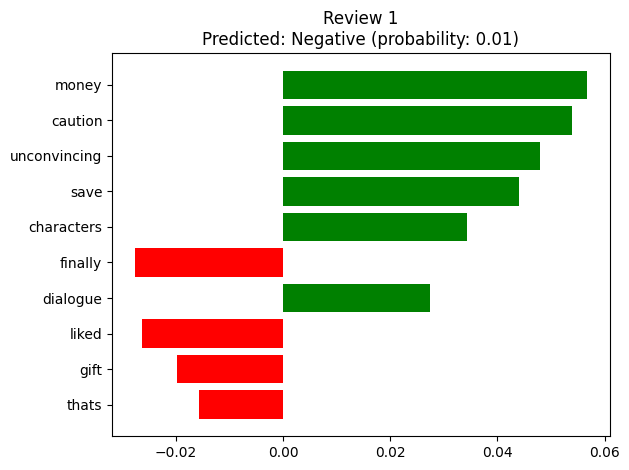


Review 1:
Text: word caution received book gift felt obliged read im sorry plot implausible predictable thats quite ...

Top contributing words:
money: 0.057
caution: 0.054
unconvincing: 0.048
save: 0.044
characters: 0.034
finally: -0.028
dialogue: 0.027
liked: -0.026
gift: -0.020
thats: -0.016


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

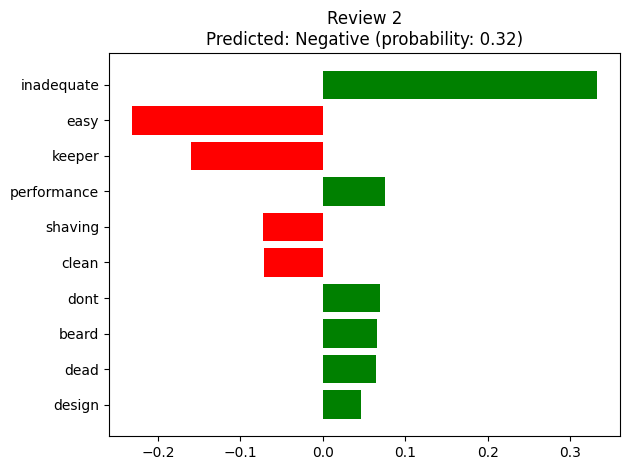


Review 2:
Text: depends beard hair pros ergonomic design quite operation easy clean soap watercons cord shaving batt...

Top contributing words:
inadequate: 0.332
easy: -0.231
keeper: -0.160
performance: 0.075
shaving: -0.072
clean: -0.071
dont: 0.070
beard: 0.065
dead: 0.065
design: 0.046


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

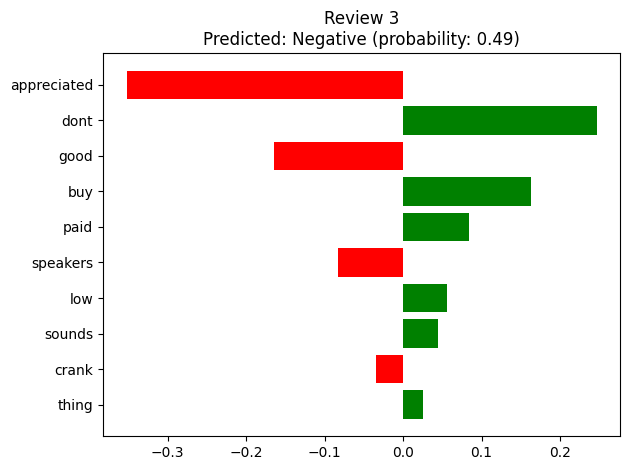


Review 3:
Text: dont buy good speakers low volume crank volume sounds different quality appreciated im sure originat...

Top contributing words:
appreciated: -0.352
dont: 0.247
good: -0.164
buy: 0.164
paid: 0.084
speakers: -0.083
low: 0.056
sounds: 0.045
crank: -0.035
thing: 0.026


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

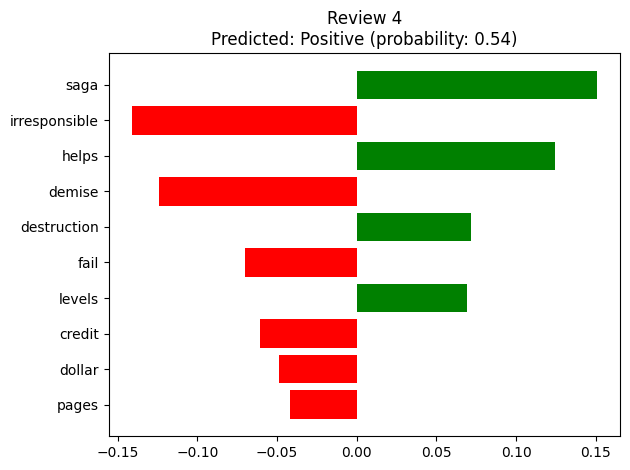


Review 4:
Text: demise dollar repititious saga read book right found said current state direction us economy could s...

Top contributing words:
saga: 0.151
irresponsible: -0.141
helps: 0.125
demise: -0.124
destruction: 0.072
fail: -0.070
levels: 0.069
credit: -0.061
dollar: -0.049
pages: -0.042


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

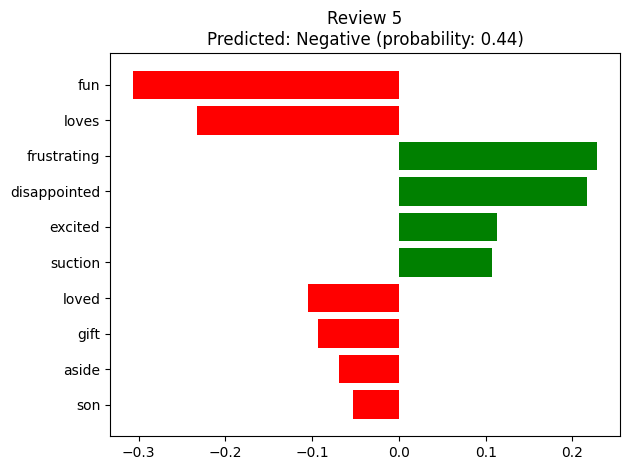


Review 5:
Text: fun frustrating 2yr old son loved gift opened excited play tub disappointed suction cups need reatta...

Top contributing words:
fun: -0.306
loves: -0.233
frustrating: 0.228
disappointed: 0.217
excited: 0.113
suction: 0.107
loved: -0.105
gift: -0.093
aside: -0.069
son: -0.053




In [9]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability of positive: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")